In [ ]:
!pip install --user kaggle

In [9]:
!mkdir /root/.kaggle

In [10]:
!mv /content/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c home-credit-default-risk

In [12]:
!ls

application_test.csv.zip	    installments_payments.csv.zip
application_train.csv.zip	    POS_CASH_balance.csv.zip
bureau_balance.csv.zip		    previous_application.csv.zip
bureau.csv.zip			    sample_data
credit_card_balance.csv.zip	    sample_submission.csv
HomeCredit_columns_description.csv


In [13]:
import os

for filename in os.listdir('.'):
    if filename.endswith('.zip'):
        os.system("unzip {}".format(filename))
        os.system("rm {}".format(filename))

In [14]:
!ls

application_test.csv		    installments_payments.csv
application_train.csv		    POS_CASH_balance.csv
bureau_balance.csv		    previous_application.csv
bureau.csv			    sample_data
credit_card_balance.csv		    sample_submission.csv
HomeCredit_columns_description.csv


In [103]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Splitting data
from sklearn.model_selection import train_test_split

N_FOLDS = 3
MAX_EVALS = 3
SEED = 42


1.   使用小数据集，Hyperparameter tuning很耗时间的
2.   调参时，固定一部分有标签训练数据，不参与训练和validation，当做假测试集，以验证模型性能。
3.    最后参数选完之后，全量数据训练或交叉验证训练，提交拟合完毕的模型结果
3.    在真正测试集上，验证模型性能

In [104]:
features = pd.read_csv('./application_train.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features：目的是为了展示参数搜索，而不是打比赛提分
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 50)

In [105]:
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)

Training features shape:  (10000, 104)
Testing features shape:  (6000, 104)


### Cross Validation

！！！建立除了固定的测试集只外的validation set。

测试数据用于作为，在真实场景下部署时模型性能的估计，因此我们不在测试数据上优化我们的模型，因为这不会对模型实际性能进行公平估计。

数据集很大时，不必KFold；数据集小的时候，KFold是有好处的。

LightGBM自带的cv，可以设置Early Stopping，这对以GBM模型，很有用。减小overfitting的风险

In [106]:
# Create a training and testing dataset
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

In [108]:
# num_boost_round is the same as n_estimators
# num_boost_round won't actually be reached because we are using early stopping

# Get default hyperparameters
model = lgb.LGBMClassifier()

default_params = model.get_params()
del default_params['n_estimators']

# Cross validation with early stopping
cv_results = lgb.cv(default_params,
                    train_set,
                    num_boost_round=10000,
                    early_stopping_rounds=100,
                    metrics='auc',
                    nfold=N_FOLDS,
                    seed=SEED)

In [109]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.69946 with a standard deviation of 0.01460.
The optimal number of boosting rounds (estimators) was 21.


查看model在test数据上的性能，在全量数据上训练，并使用最优参数。

In [110]:
from sklearn.metrics import roc_auc_score

# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.72723 ROC AUC on the test set.


以上只是搜索了最优的树的个数

### Hyperparameter tuning的四大组成部分



1.   Objective function: 以超参数组合为输入，score为输出
2.   Domain：超参数搜索范围
3.   Algorithm：搜索下一个参数组合的算法
4.   Results history：超参数组合与得分的储存数据结构



#### Objective function

In [139]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
    if hyperparameters['boosting_type'] == 'dart':
        num_boost_round = 100
    else:
        num_boost_round = 10000
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = num_boost_round, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [112]:
score, params, iteration = objective(default_params, 1)

Domain

In [113]:
# Create a default model
model_ = lgb.LGBMModel()
model_.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [114]:
del model_

min_child_samples and min_child_weight只用调整其中之一

搜索先从大范围，调整到小范围

In [115]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

boosting_type为goss时，subsample要设置为1.0

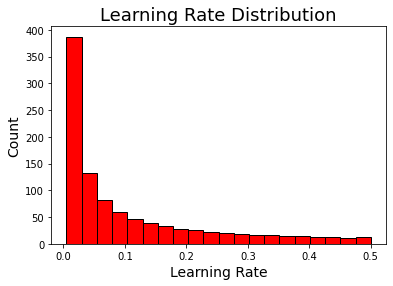

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Learning rate histogram
plt.hist(param_grid['learning_rate'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

In [117]:
# 查看区间范围内数值个数分布
a = 0
b = 0

# Check number of values in each category
for x in param_grid['learning_rate']:
    # Check values
    if x >= 0.005 and x < 0.05:
        a += 1
    elif x >= 0.05 and x < 0.5:
        b += 1

print('There are {} values between 0.005 and 0.05'.format(a))
print('There are {} values between 0.05 and 0.5'.format(b))

There are 499 values between 0.005 and 0.05
There are 499 values between 0.05 and 0.5


#### Algorithm

grid  search

random search

bayes search

#### grid search

In [29]:
com = 1
for x in param_grid.values():
    com *= len(x)
print('There are {} combinations'.format(com))

There are 2620800000000000 combinations


组合太多

In [118]:
print('This would take {:.0f} years to finish.'.format((100 * com) / (60 * 60 * 24 * 365)))

This would take 8310502283 years to finish.


In [119]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # 为了演示，限制次数。另外，真实数据上grid search也不会把空间设置这么大。只用作演示。
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results 

In [120]:
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 0.72303

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.004999999999999999,
 'min_child_samples': 20,
 'n_estimators': 448,
 'num_leaves': 20,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5,
 'subsample_for_bin': 20000}


test set上查看搜索出的模型的性能

In [121]:
# Get the best parameters
grid_search_params = grid_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**grid_search_params, random_state=42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from grid search scores 0.73272 ROC AUC on the test set.


In [122]:
# 查看历史记录
pd.options.display.max_colwidth = 10
grid_results['params'].values

array([{'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': True, 'n_estimators': 448},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': False, 'n_estimators': 448},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5050505050505051, 'is_unbalance': True, 'n_estimators': 448},
       {'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'co

subsample 和 is_unbalance 的变化对模型性能影响不大

#### Random Search

还不错的模型，可以在可接受时间范围内实验

In [123]:
import random

random.seed(50)

# Randomly sample from dictionary
random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
# Deal with subsample ratio
random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

random_params

{'boosting_type': 'goss',
 'colsample_bytree': 0.8222222222222222,
 'is_unbalance': False,
 'learning_rate': 0.027778881111994384,
 'min_child_samples': 175,
 'num_leaves': 88,
 'reg_alpha': 0.8979591836734693,
 'reg_lambda': 0.6122448979591836,
 'subsample': 1.0,
 'subsample_for_bin': 220000}

In [142]:
import tqdm

In [151]:
def random_search(param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in tqdm.tqdm(range(MAX_EVALS)):
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [152]:
random_results = random_search(param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'params'])



  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

 67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

The best validation score was 0.71919

The best hyperparameters were:
{'boosting_type': 'dart',
 'colsample_bytree': 0.9555555555555555,
 'is_unbalance': False,
 'learning_rate': 0.06577928120228521,
 'min_child_samples': 295,
 'n_estimators': 100,
 'num_leaves': 105,
 'reg_alpha': 0.5306122448979591,
 'reg_lambda': 0.6122448979591836,
 'subsample': 0.51010101010101,
 'subsample_for_bin': 220000}


In [153]:
# Get the best parameters
random_search_params = random_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**random_search_params, random_state = 42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from random search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from random search scores 0.73065 ROC AUC on the test set.


In [154]:
random_results['params']

0    {'boos...
1    {'boos...
2    {'boos...
Name: params, dtype: object

### Practice

In [156]:
import csv

# Create file and open connection
out_file = 'random_search_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()


def random_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization. 
       Writes result of search to csv file every search iteration."""
    
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    for i in tqdm.tgrange(MAX_EVALS):
        
        # Choose random hyperparameters
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(random_params, i)
        results.loc[i, :] = eval_results

        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)

    return results 


def grid_search(param_grid, out_file, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)
       Writes result of search to csv file every search iteration."""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        # Select the hyperparameters
        parameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        parameters['subsample'] = 1.0 if parameters['boosting_type'] == 'goss' else parameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(parameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # open connection (append option) and write results
        of_connection = open(out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow(eval_results)
        
        # make sure to close connection
        of_connection.close()
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

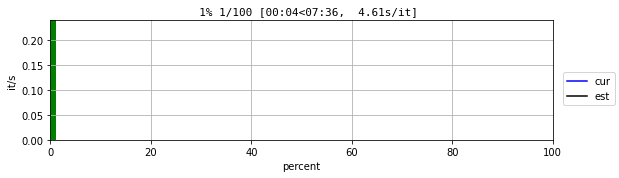

In [157]:
MAX_EVALS = 100

# Create file and open connection
out_file = 'grid_search_trials_1000.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

grid_results = grid_search(param_grid, out_file)


# Create file and open connection
out_file = 'random_search_trials_1000.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['score', 'hyperparameters', 'iteration']
writer.writerow(headers)
of_connection.close()

random_results = random_search(param_grid, out_file)

#### Stacking Random and Grid Search

1. 对大范围超参数使用随机搜索

2. 使用随机搜索的结果围绕性能最佳的超参数值构建小范围的超参数网格。

3. 在小范围的超参数网格上运行网格搜索。

4. 在更小范围的网格上重复网格搜索，直到超过最大的计算/时间预算。

### Automated Hyperparameter Tuning

建立代理函数，代替objective function P(score|hyperparameters)，使得参数搜索计算代价变小

常用算法：Gaussian Process (implemented in Spearmint), Random Forest Regression (in SMAC), and the Tree Parzen Estimator (TPE) in Hyperopt.

以上算法细节，对于使用者不是必须知道的。

#### Hyperopt

Hyperopt是一个开源Python库，它使用Tree Parzen Estimator算法来构造代理函数并选择下一个要在目标函数中求值的超参数值来实现贝叶斯优化。

其他库：Spearmint (Guassian process surrogate function) and SMAC (random forest regression surrogate function)

Gradient Boosting Machine的表现非常依赖超参数

In [39]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
%matplotlib inline

# Governing choices for search
N_FOLDS = 3
MAX_EVALS = 3

In [40]:
features = pd.read_csv('application_train.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (10000, 104)
Test shape:  (6000, 104)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
99825,2,99000.0,562491.0,27189.0,454500.0,0.007330,-10901,-603,-574.0,-3572,22.0,1,1,0,1,0,0,4.0,2,2,11,0,0,0,0,1,1,NaN,0.364905,0.652897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
208378,0,157500.0,677664.0,34731.0,585000.0,0.024610,-12091,-1358,-2918.0,-3715,NaN,1,1,1,1,1,0,1.0,2,2,15,1,1,0,1,1,0,0.298256,0.598669,0.661024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-560.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,6.0
1309,2,112500.0,864000.0,25393.5,864000.0,0.028663,-11922,-1868,-1465.0,-4580,NaN,1,1,0,1,1,0,4.0,2,2,10,0,0,0,0,0,0,NaN,0.240739,0.577969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,3.0,0.0,-1206.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
172223,1,63000.0,180000.0,9000.0,180000.0,0.020246,-14570,-7753,-5007.0,-4719,NaN,1,1,0,1,0,0,3.0,3,3,11,0,0,0,0,1,1,0.146889,0.428255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-709.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
258157,0,202500.0,1193580.0,42417.0,855000.0,0.020713,-20925,-1049,-3149.0,-4437,64.0,1,1,0,1,0,0,2.0,3,2,12,0,0,0,0,0,0,NaN,0.053220,0.569149,0.1732,0.1072,0.9742,0.6464,0.0718,0.0,0.0345,0.1667,0.2083,0.0552,...,0.0345,0.1667,0.2083,0.0562,0.1437,0.0594,0.0,0.0,0.0851,4.0,0.0,4.0,0.0,-1184.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


#### Baseline Model

In [41]:
model = lgb.LGBMClassifier(random_state=50)

# Training set
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

In [42]:
# Default hyperparamters
hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


The maximium ROC AUC in cross validation was 0.71422 with std of 0.00859.
The ideal number of iterations was 23.


In [43]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.71599 ROC AUC on the test set.


#### Objective Function

In [87]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    num_boost_round = hyperparameters['boosting_type'].get('num_boost_round', 100)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    hyperparameters['num_boost_round'] = num_boost_round
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

#### Domain

通过Hyperopt进行参数搜索空间的分布设定

In [45]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [46]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

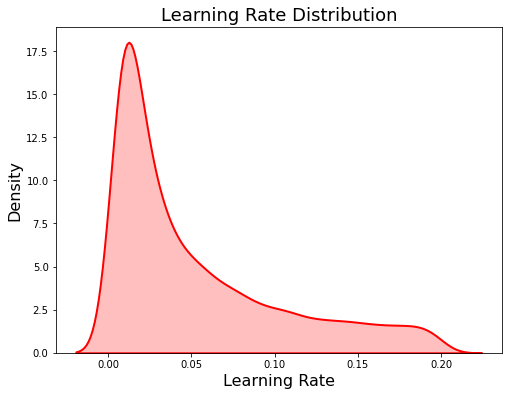

In [47]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

0.005 to 0.05 和 0.05 to 0.5，面积（概率）是相同的

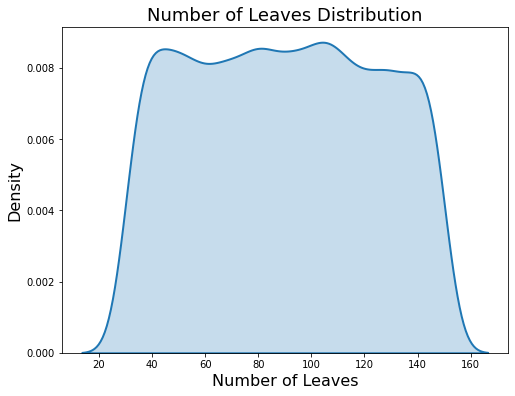

In [48]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

设置嵌套条件分布

In [51]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
hyperparams = sample(boosting_type)
hyperparams

{'boosting_type': {'boosting_type': 'dart', 'subsample': 0.8488126272665351}}

下面将嵌套条件分布设置为hyperparams字典的一级key，可以直接通过hyperparams['key']取得，以供模型调用

In [50]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = hyperparams['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
hyperparams['boosting_type'] = hyperparams['boosting_type']['boosting_type']
hyperparams['subsample'] = subsample

hyperparams

{'boosting_type': 'goss', 'subsample': 1.0}

完整示例

注意：dart算法会随机删除树，所以early stopping的轮次是不准确的，设置num_boost_round来限制运行时间，否则随机删减树的情况下，在early stopping设置较大时，会运行很久

In [71]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1), 'num_boost_round': 10000}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1), 'num_boost_round': 100},
                                             {'boosting_type': 'goss', 'subsample': 1.0, 'num_boost_round': 10000}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

In [72]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
num_boost_round = x['boosting_type'].get('num_boost_round', 100)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x['num_boost_round'] = num_boost_round

x

{'boosting_type': 'goss',
 'colsample_bytree': 0.6854834525236063,
 'is_unbalance': True,
 'learning_rate': 0.125376466466906,
 'min_child_samples': 305.0,
 'num_boost_round': 10000,
 'num_leaves': 38.0,
 'reg_alpha': 0.34252351012849724,
 'reg_lambda': 0.5000608098758048,
 'subsample': 1.0,
 'subsample_for_bin': 260000.0}

In [73]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
num_boost_round = x['boosting_type'].get('num_boost_round', 100)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['num_boost_round'] = num_boost_round
x

{'boosting_type': 'dart',
 'colsample_bytree': 0.8777154328711796,
 'is_unbalance': False,
 'learning_rate': 0.2209865884762597,
 'min_child_samples': 445.0,
 'num_boost_round': 100,
 'num_leaves': 30.0,
 'reg_alpha': 0.5060449310596051,
 'reg_lambda': 0.06643649512995475,
 'subsample_for_bin': 120000.0}

运行

In [55]:
# Create a new file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Test the objective function
results = objective(sample(space))
print('The cross validation loss = {:.5f}.'.format(results['loss']))
print('The optimal number of estimators was {}.'.format(results['hyperparameters']['n_estimators']))

The cross validation loss = 0.27914.
The optimal number of estimators was 21.


### Optimization Algorithm

Hyperopt 有两种选择: random search， Tree Parzen Estimator.

In [59]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest

### Results History

使用Trials对象保存objective function返回的结果，通过 '.results' 属性查看。为了方便查看，也可以保存为csv文件

In [84]:
from hyperopt import Trials

# Record results
trials = Trials()


# Create a file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

### Practice

In [57]:
from hyperopt import fmin

In [88]:
# Global variable
global  ITERATION

ITERATION = 0
MAX_EVALS = 3

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

best

  0%|          | 0/3 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



 33%|███▎      | 1/3 [00:00<00:00,  2.04it/s, best loss: 0.296164020532398]

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



 67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it, best loss: 0.296164020532398]

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



100%|██████████| 3/3 [00:03<00:00,  1.14s/it, best loss: 0.296164020532398]


{'boosting_type': 2,
 'colsample_by_tree': 0.6422431172189369,
 'is_unbalance': 1,
 'learning_rate': 0.22783673651296196,
 'min_child_samples': 495.0,
 'num_leaves': 127.0,
 'reg_alpha': 0.005315819074972583,
 'reg_lambda': 0.45115717354521245,
 'subsample_for_bin': 280000.0}

In [89]:
# Sort the trials with lowest loss (highest AUC) first
trials_dict = sorted(trials.results, key = lambda x: x['loss'])
trials_dict[:1]

[{'hyperparameters': {'boosting_type': 'goss',
   'colsample_bytree': 0.6422431172189369,
   'is_unbalance': False,
   'learning_rate': 0.22783673651296196,
   'min_child_samples': 495,
   'n_estimators': 6,
   'num_boost_round': 10000,
   'num_leaves': 127,
   'reg_alpha': 0.005315819074972583,
   'reg_lambda': 0.45115717354521245,
   'subsample': 1.0,
   'subsample_for_bin': 280000},
  'iteration': 1,
  'loss': 0.296164020532398,
  'status': 'ok',
  'train_time': 0.48014454200165346}]

In [64]:
results = pd.read_csv(OUT_FILE)

In [65]:
import ast

def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
    
    new_results = results.copy()
    # String to dictionary: csv保存时默认为string，ast.literal_eval将其变为字典
    new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sort with best values on top
    new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(new_results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(new_results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = new_results['iteration']
    hyp_df['score'] = new_results['score']
    
    return hyp_df

In [66]:
bayes_results = evaluate(results, name = 'Bayesian')
bayes_results

The highest cross validation score from Bayesian was 0.72521 found on iteration 2.
ROC AUC from Bayesian on test data = 0.73096.


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,n_estimators,iteration,score
0,gbdt,0.648677,False,0.019741,360,58,0.574665,0.411478,280000,0.601826,265,2,0.725207
1,gbdt,0.650436,False,0.025716,285,108,0.957777,0.212348,60000,0.732862,129,1,0.724260
2,goss,0.724805,False,0.018820,75,113,0.993782,0.165252,240000,1.000000,54,3,0.719422


#### Continue Optimization

只要传入有参数的trail对象，就可以继续训练

In [90]:
MAX_EVALS = 10

# Continue training
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

  0%|          | 0/7 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



 14%|█▍        | 1/7 [00:01<00:06,  1.15s/it, best loss: 0.2849970373731746]

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



 29%|██▊       | 2/7 [00:02<00:06,  1.24s/it, best loss: 0.2849970373731746]

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



 43%|████▎     | 3/7 [00:03<00:04,  1.03s/it, best loss: 0.2849970373731746]

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



 57%|█████▋    | 4/7 [00:05<00:04,  1.57s/it, best loss: 0.28374325513266163]

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))

/usr/local/lib/python3.6/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



 71%|███████▏  | 5/7 [00:07<00:03,  1.57s/it, best loss: 0.28189243060584135]

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



 86%|████████▌ | 6/7 [00:13<00:02,  2.87s/it, best loss: 0.2790754976673089] 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



100%|██████████| 7/7 [00:14<00:00,  2.00s/it, best loss: 0.2790754976673089]


In [98]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_dict))

在随机和网格搜索实验中，来自小数据集的最佳超参数值不一定在全数据集上表现良好。

### Practice

In [96]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
MAX_EVALS = 200

# Create a new file and open a connection
OUT_FILE = 'bayesian_trials_1000.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Record results
trials = Trials()

global ITERATION

ITERATION = 0 

best = fmin(fn = objective, space = space, algo = tpe.suggest,
            trials = trials, max_evals = MAX_EVALS)

# Sort the trials with lowest loss (highest AUC) first
trials_dict = sorted(trials.results, key = lambda x: x['loss'])

print('Finished, best results')
print(trials_dict[:1])

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_dict))

#### 结果查看

In [158]:
bayes_results = pd.read_csv('bayesian_trials_1000.csv').sort_values('score', ascending = False).reset_index()
random_results = pd.read_csv('random_search_trials_1000.csv').sort_values('score', ascending = False).reset_index()
random_results['loss'] = 1 - random_results['score']

bayes_params = evaluate(bayes_results, name = 'Bayesian')
random_params = evaluate(random_results, name = 'random')

The highest cross validation score from Bayesian was 0.72901 found on iteration 165.
ROC AUC from Bayesian on test data = 0.67643.
The highest cross validation score from random was 0.72907 found on iteration 62.
ROC AUC from random on test data = 0.73666.


In [159]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': random_params['score'], 'iteration': random_params['iteration'], 'search': 'Random'})
scores = scores.append(pd.DataFrame({'ROC AUC': bayes_params['score'], 'iteration': bayes_params['iteration'], 'search': 'Bayesian'}))

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

,ROC AUC,iteration,search
0,0.729068,62,Random
1,0.728837,73,Random
2,0.728743,60,Random
3,0.727865,7,Random
4,0.727340,69,Random


In [160]:
best_random_params = random_params.iloc[random_params['score'].idxmax(), :].copy()
best_bayes_params = bayes_params.iloc[bayes_params['score'].idxmax(), :].copy()

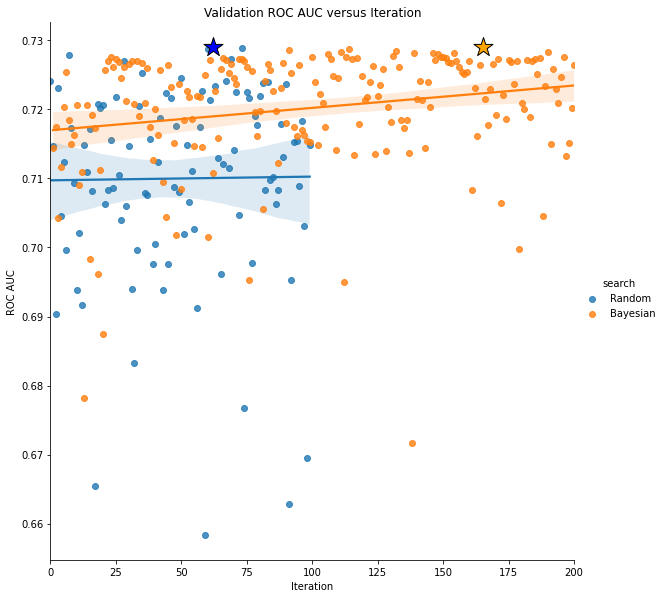

In [161]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, size = 8);
plt.scatter(best_bayes_params['iteration'], best_bayes_params['score'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.scatter(best_random_params['iteration'], best_random_params['score'], marker = '*', s = 400, c = 'blue', edgecolor = 'k')
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration");

In [ ]:
!pip install vega

In [164]:
import altair as alt

alt.renderers.enable('notebook')

c = alt.Chart(scores).mark_circle().encode(x = 'iteration', y = alt.Y('ROC AUC', 
                                                                  scale = alt.Scale(domain = [0.64, 0.74])),
                                       color = 'search')
c.title = 'Validation ROC AUC vs Iteration'
c

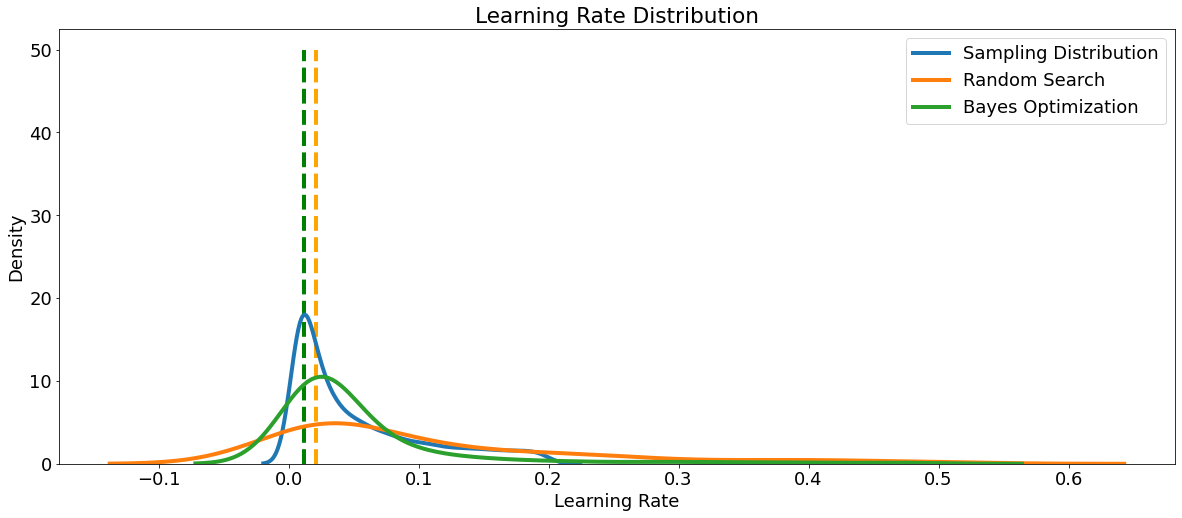

In [165]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 4)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 4)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 4)
plt.vlines([best_random_params['learning_rate'], best_bayes_params['learning_rate']],
           ymin = 0.0, ymax = 50.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

In [ ]:
list(random_params['num_leaves'])

num_leaves


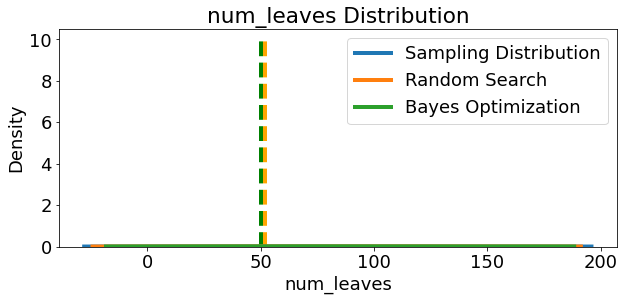

subsample_for_bin


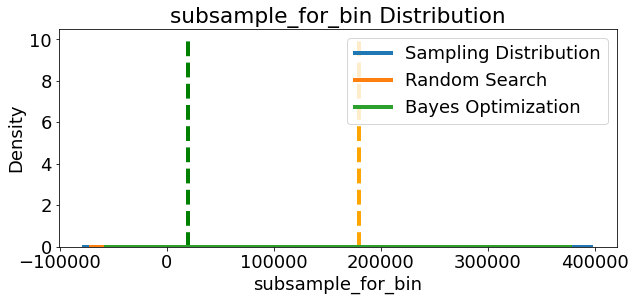

min_child_samples


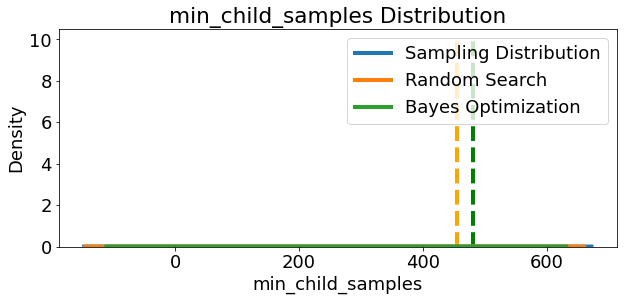

reg_alpha


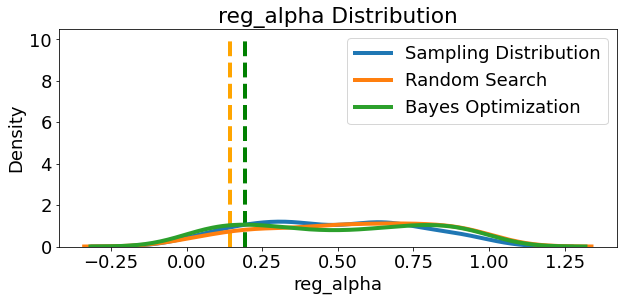

reg_lambda


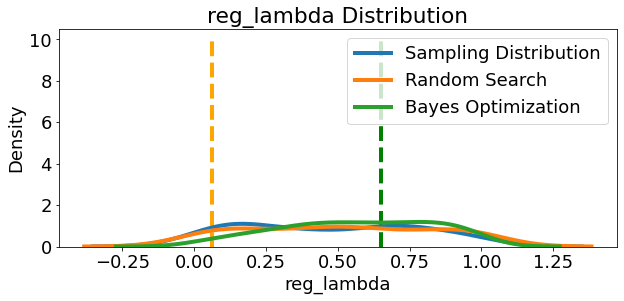

colsample_bytree


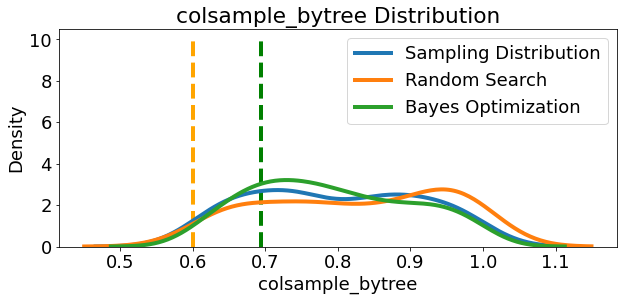

In [179]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'n_estimators', 'score', 'is_unbalance',
                    'boosting_type', 'iteration', 'subsample', 'metric', 'verbose', 'loss', 'learning_rate']:
        plt.figure(figsize = (10, 4))
        print(hyper)
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(100)], label = 'Sampling Distribution', linewidth = 4)
        sns.kdeplot(list(random_params[hyper]), label = 'Random Search', linewidth = 4)
        sns.kdeplot(list(bayes_params[hyper]), label = 'Bayes Optimization', linewidth = 4)
        plt.vlines([best_random_params[hyper], best_bayes_params[hyper]],
                     ymin = 0.0, ymax = 10.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.autoscale()
        plt.show();

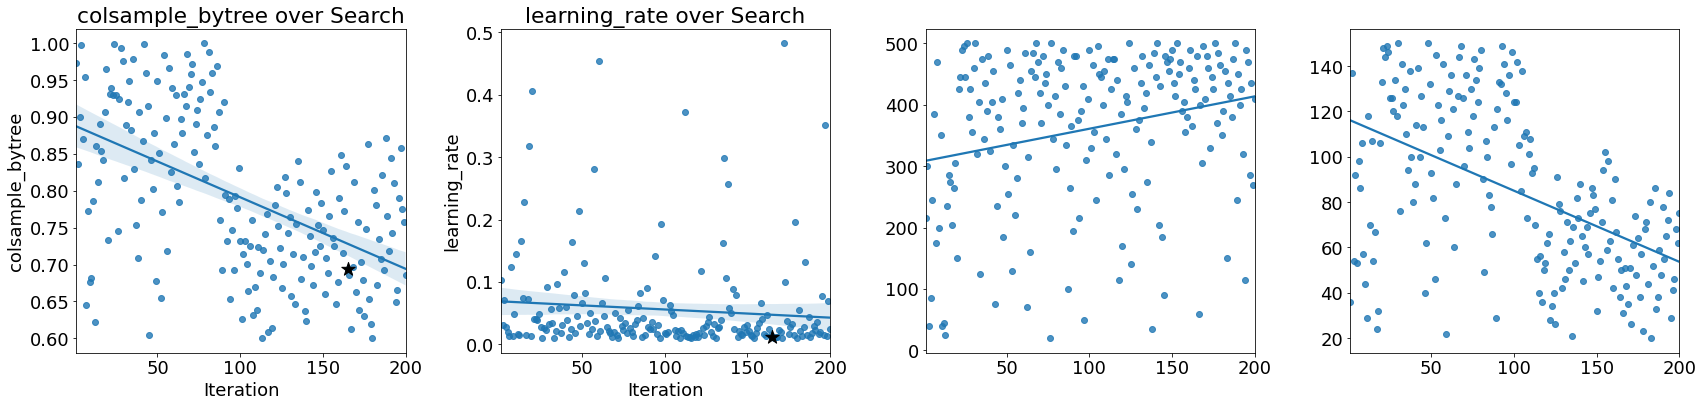

In [181]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        try:
            sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
            axs[i].scatter(best_bayes_params['iteration'], best_bayes_params[hyper], marker = '*', s = 200, c = 'k')
            axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));
        except Exception:
            pass

plt.tight_layout()


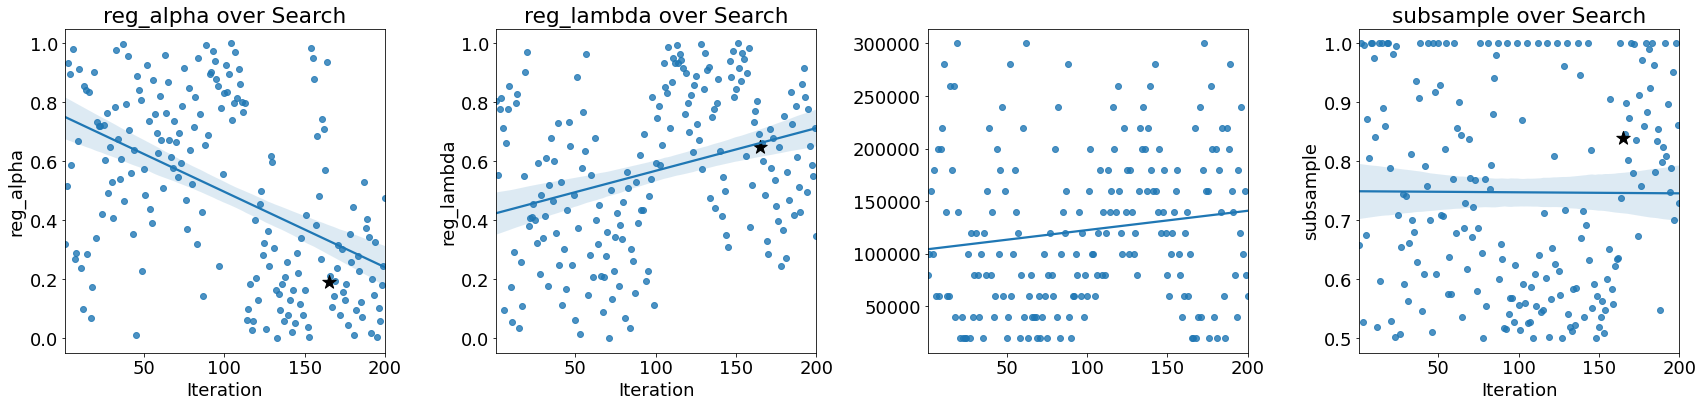

In [183]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Scatterplot of next three hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin', 'subsample']):
        try:
            sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
            axs[i].scatter(best_bayes_params['iteration'], best_bayes_params[hyper], marker = '*', s = 200, c = 'k')
            axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));
        except Exception:
            pass

plt.tight_layout()

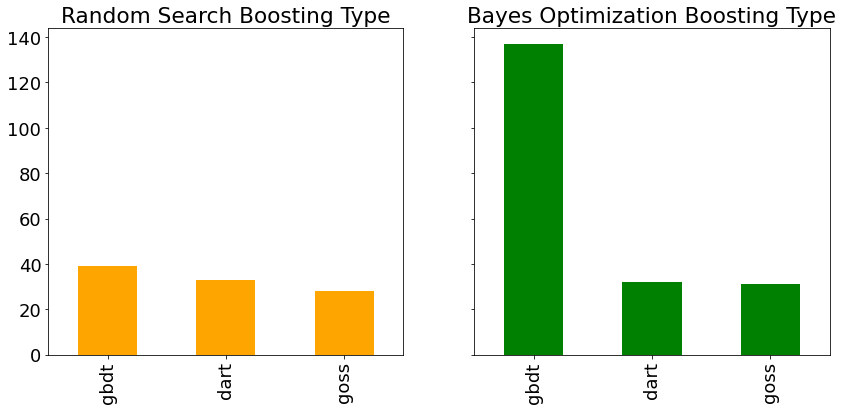

In [184]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

In [185]:
bars = alt.Chart(random_params, width = 500).mark_bar(color = 'orange').encode(x = 'boosting_type', y = alt.Y('count()', scale = alt.Scale(domain = [0, 400])))
text = bars.mark_text(size = 20, align = 'center', baseline = 'bottom').encode(text = 'count()')

bars + text

In [186]:
bars = alt.Chart(bayes_params, width = 500).mark_bar(color = 'green').encode(x = 'boosting_type', y = alt.Y('count()', scale = alt.Scale(domain = [0, 800])))
text = bars.mark_text(size = 20, align = 'center', baseline = 'bottom').encode(text = 'count()')

bars + text

## 结论

贝叶斯超参数优化：

1. 测试集上更好的泛化性能

2. 迭代次数少于随机或网格搜索所需的次数

贝叶斯优化(或其他自动超参数调优方法)并不是在所有情况下都能达到上述要求。为了不把时间耗费在超参搜索上，这些类似的方法是值得掌握的。